# LDA model using sklearn

In [2]:
# Usual imports
import numpy as np
import pandas as pd
from tqdm import tqdm,tqdm_notebook
import string
import matplotlib.pyplot as plt
from sklearn.decomposition import NMF, LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
import concurrent.futures
import time
import pyLDAvis.sklearn
from pylab import bone, pcolor, colorbar, plot, show, rcParams, savefig
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
import os
print(os.listdir("../data"))

# Plotly based imports for visualization
from plotly import tools
import chart_studio.plotly as py
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.figure_factory as ff

# spaCy based imports
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English
import bz2
import re

#!python -m spacy download en_core_web_lg

['.ipynb_checkpoints', 'Bag_Reviews.xlsx', 'for_w2v', 'models', 'productReviewShopee_1.csv']


## Read file

In [169]:
# reviews_ms = pd.read_excel('../data/Bag_Reviews.xlsx')
reviews_ms = pd.read_csv('/home/gpu1/work_space/disk3_work_space3/CRM_Topic_models/input/amazon_cloth_shoe_watches_reviews_with_title.csv')
#reviews_ms = reviews_ms[['rating','comments']]
reviews_ms.head()

,comments,rating,asin,brand,title,categories
0,Perfect red tutu for the price. I baught it as...,5.0,0000031887,Boutique Cutie,Ballet Dress-Up Fairy Tutu,"[['Clothing, Shoes & Jewelry', 'Girls', 'Cloth..."
1,This was a really cute tutu the only problem i...,4.0,0000031887,Boutique Cutie,Ballet Dress-Up Fairy Tutu,"[['Clothing, Shoes & Jewelry', 'Girls', 'Cloth..."
2,the tutu color was very nice. the only issue w...,2.0,0000031887,Boutique Cutie,Ballet Dress-Up Fairy Tutu,"[['Clothing, Shoes & Jewelry', 'Girls', 'Cloth..."
3,My 3-yr-old daughter received this as a gift f...,1.0,0000031887,Boutique Cutie,Ballet Dress-Up Fairy Tutu,"[['Clothing, Shoes & Jewelry', 'Girls', 'Cloth..."
4,Bought it for my daughters first birthday whic...,4.0,0000031887,Boutique Cutie,Ballet Dress-Up Fairy Tutu,"[['Clothing, Shoes & Jewelry', 'Girls', 'Cloth..."


In [55]:
reviews_ms.title.value_counts()

Levi's Men's 505 Regular-Fit Jean                                                                  2212
Levi's Men's 501 Original Fit Jean                                                                 2098
Converse Unisex Chuck Taylor Classic Colors Sneaker                                                1311
Converse Unisex Chuck Taylor All Star Hi Top Black Monochrome Sneaker                              1224
Merrell Men's Jungle Moc Slip-On Shoe                                                               950
Rockport Men's World Tour Classic Walking Shoe                                                      928
Carhartt Men's Workwear Pocket T-Shirt K87                                                          916
Dickies Men's Original 874 Work Pant                                                                817
KEEN Women's Venice H2 Sandal                                                                       815
Kidoozie My First Purse                                         

In [56]:
reviews_ms = reviews_ms[reviews_ms.title=="Levi's Men's 505 Regular-Fit Jean"]

In [57]:
reviews_ms.shape

(2212, 7)

### Remove Duplicates 

In [58]:
reviews_ms.drop_duplicates().shape

(2212, 7)

In [59]:
reviews_ms=reviews_ms.drop_duplicates()
reviews_ms.head()

,comments,rating,asin,brand,title,categories,len_review
47689,My husband just likes Levi's and these did not...,5.0,B00012O12A,NaN,Levi's Men's 505 Regular-Fit Jean,"[['Clothing, Shoes & Jewelry', 'Men', 'Clothin...",123
47690,I ordered these jeans for my son as a Christma...,5.0,B00012O12A,NaN,Levi's Men's 505 Regular-Fit Jean,"[['Clothing, Shoes & Jewelry', 'Men', 'Clothin...",258
47691,"The one pair that I recieved was clearly a ""se...",3.0,B00012O12A,NaN,Levi's Men's 505 Regular-Fit Jean,"[['Clothing, Shoes & Jewelry', 'Men', 'Clothin...",187
47692,There was nothing in the description about the...,2.0,B00012O12A,NaN,Levi's Men's 505 Regular-Fit Jean,"[['Clothing, Shoes & Jewelry', 'Men', 'Clothin...",569
47693,I'm not sure what the other reviewers issues a...,4.0,B00012O12A,NaN,Levi's Men's 505 Regular-Fit Jean,"[['Clothing, Shoes & Jewelry', 'Men', 'Clothin...",444


### Remove very small text

In [60]:
reviews_ms.comments=reviews_ms.comments.astype(str)
reviews_ms['len_review']=reviews_ms.comments.apply(len)

In [61]:
reviews_ms.len_review.describe()

count    2212.000000
mean      279.389693
std       289.130780
min         5.000000
25%       124.000000
50%       180.000000
75%       327.000000
max      4811.000000
Name: len_review, dtype: float64

In [62]:
reviews_ms.comments=reviews_ms.comments.apply(lambda x: x.replace('👍','good '))
reviews_ms.head()

,comments,rating,asin,brand,title,categories,len_review
47689,My husband just likes Levi's and these did not...,5.0,B00012O12A,NaN,Levi's Men's 505 Regular-Fit Jean,"[['Clothing, Shoes & Jewelry', 'Men', 'Clothin...",123
47690,I ordered these jeans for my son as a Christma...,5.0,B00012O12A,NaN,Levi's Men's 505 Regular-Fit Jean,"[['Clothing, Shoes & Jewelry', 'Men', 'Clothin...",258
47691,"The one pair that I recieved was clearly a ""se...",3.0,B00012O12A,NaN,Levi's Men's 505 Regular-Fit Jean,"[['Clothing, Shoes & Jewelry', 'Men', 'Clothin...",187
47692,There was nothing in the description about the...,2.0,B00012O12A,NaN,Levi's Men's 505 Regular-Fit Jean,"[['Clothing, Shoes & Jewelry', 'Men', 'Clothin...",569
47693,I'm not sure what the other reviewers issues a...,4.0,B00012O12A,NaN,Levi's Men's 505 Regular-Fit Jean,"[['Clothing, Shoes & Jewelry', 'Men', 'Clothin...",444


In [63]:
s_limit=50
max_limit=1300
reviews=reviews_ms.loc[(reviews_ms.len_review>=s_limit) & (reviews_ms.len_review<max_limit),:]
reviews.head()

,comments,rating,asin,brand,title,categories,len_review
47689,My husband just likes Levi's and these did not...,5.0,B00012O12A,NaN,Levi's Men's 505 Regular-Fit Jean,"[['Clothing, Shoes & Jewelry', 'Men', 'Clothin...",123
47690,I ordered these jeans for my son as a Christma...,5.0,B00012O12A,NaN,Levi's Men's 505 Regular-Fit Jean,"[['Clothing, Shoes & Jewelry', 'Men', 'Clothin...",258
47691,"The one pair that I recieved was clearly a ""se...",3.0,B00012O12A,NaN,Levi's Men's 505 Regular-Fit Jean,"[['Clothing, Shoes & Jewelry', 'Men', 'Clothin...",187
47692,There was nothing in the description about the...,2.0,B00012O12A,NaN,Levi's Men's 505 Regular-Fit Jean,"[['Clothing, Shoes & Jewelry', 'Men', 'Clothin...",569
47693,I'm not sure what the other reviewers issues a...,4.0,B00012O12A,NaN,Levi's Men's 505 Regular-Fit Jean,"[['Clothing, Shoes & Jewelry', 'Men', 'Clothin...",444


In [64]:
reviews.shape

(2159, 7)

### loading spacy

In [65]:
# Creating a spaCy object
nlp = spacy.load('en_core_web_lg')

### Named Entity Recognition
 Named Entity Recognition is an information extraction task where named entities in unstructured sentences are located and classified  in some pre-defined categories such as the person names, organizations, locations, medical codes, time expressions, quantities, monetary values, percentages, etc.

In [72]:
doc = nlp(reviews["comments"].iloc[0])
spacy.displacy.render(doc, style='ent',jupyter=True)

In [73]:
punctuations = string.punctuation
stopwords = list(STOP_WORDS)

### Lemmatization
It is the  process of grouping together the inflected forms of a word so they can be analysed as a single item, identified by the word's lemma, or dictionary form. Words like "ran" and "running" are converted to "run" to avoid having words with similar meanings in our data.

In [74]:
review = str("".join([i.lemma_ for i in doc]))

In [75]:
doc = nlp(review)
spacy.displacy.render(doc, style='ent',jupyter=True)

In [76]:
doc = nlp("I would like to donate to children because I saw that the price was not expensive and we didn't have a lot of capital.")
spacy.displacy.render(doc, style='ent',jupyter=True)

### Parts of Speech tagging

This is the process of marking up a word in a text (corpus) as corresponding to a particular part of speech,[1] based on both its definition and its context—i.e., its relationship with adjacent and related words in a phrase, sentence, or paragraph. A simplified form of this is commonly taught to school-age children, in the identification of words as nouns, verbs, adjectives, adverbs, etc.

In [77]:
# Parser for reviews
parser = English()
def spacy_tokenizer(sentence):
    mytokens = parser(sentence)
    mytokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]
    mytokens = [ word for word in mytokens if word not in stopwords and word not in punctuations ]
    mytokens = " ".join([i for i in mytokens])
    return mytokens

In [78]:
tqdm.pandas()
reviews["processed_description"] = reviews["comments"].progress_apply(spacy_tokenizer)

100%|██████████| 2159/2159 [00:00<00:00, 2211.41it/s]


In [79]:
reviews

,comments,rating,asin,brand,title,categories,len_review,processed_description
47689,My husband just likes Levi's and these did not...,5.0,B00012O12A,NaN,Levi's Men's 505 Regular-Fit Jean,"[['Clothing, Shoes & Jewelry', 'Men', 'Clothin...",123,husband like levi disappoint like 505s buy til...
47690,I ordered these jeans for my son as a Christma...,5.0,B00012O12A,NaN,Levi's Men's 505 Regular-Fit Jean,"[['Clothing, Shoes & Jewelry', 'Men', 'Clothin...",258,order jeans son christmas gift jeans wear 5 st...
47691,"The one pair that I recieved was clearly a ""se...",3.0,B00012O12A,NaN,Levi's Men's 505 Regular-Fit Jean,"[['Clothing, Shoes & Jewelry', 'Men', 'Clothin...",187,pair recieved clearly 2 flaw pair sell major r...
47692,There was nothing in the description about the...,2.0,B00012O12A,NaN,Levi's Men's 505 Regular-Fit Jean,"[['Clothing, Shoes & Jewelry', 'Men', 'Clothin...",569,description pant latex wrong comfortable bend ...
47693,I'm not sure what the other reviewers issues a...,4.0,B00012O12A,NaN,Levi's Men's 505 Regular-Fit Jean,"[['Clothing, Shoes & Jewelry', 'Men', 'Clothin...",444,sure reviewer issue pant decent pair dollar le...
47694,The front pockets are tiny -- too small for my...,1.0,B00012O12A,NaN,Levi's Men's 505 Regular-Fit Jean,"[['Clothing, Shoes & Jewelry', 'Men', 'Clothin...",293,pocket tiny -- small phone change fit past cha...
47695,As usual its been my ol time favourite. The sh...,4.0,B00012O12A,NaN,Levi's Men's 505 Regular-Fit Jean,"[['Clothing, Shoes & Jewelry', 'Men', 'Clothin...",122,usual old time favourite ship fast expect purc...
47696,Service was good. Order another color and it w...,4.0,B00012O12A,NaN,Levi's Men's 505 Regular-Fit Jean,"[['Clothing, Shoes & Jewelry', 'Men', 'Clothin...",151,service good order color order stock bad pair ...
47697,"Hey I love Levis 505 Straight Fit, for the per...",2.0,B00012O12A,NaN,Levi's Men's 505 Regular-Fit Jean,"[['Clothing, Shoes & Jewelry', 'Men', 'Clothin...",316,hey love levis 505 straight fit perfect way si...
47698,"The quality of this product was intact, howeve...",4.0,B00012O12A,NaN,Levi's Men's 505 Regular-Fit Jean,"[['Clothing, Shoes & Jewelry', 'Men', 'Clothin...",117,quality product intact jeans regular fit littl...


# Topic-modelling

In [161]:
# Creating a vectorizer
vectorizer = CountVectorizer(min_df=1, max_df=1.0, stop_words='english', lowercase=True, token_pattern='[a-zA-Z\-][a-zA-Z\-]{2,}')
data_vectorized = vectorizer.fit_transform(reviews["processed_description"])

In [167]:
reviews["processed_description"].iloc[0]

'husband like levi disappoint like 505s buy till quit'

In [162]:
NUM_TOPICS = 4

# before training/inference:
np.random.seed(46)

## LDA

In [163]:
# Latent Dirichlet Allocation Model
lda = LatentDirichletAllocation(n_components=NUM_TOPICS, max_iter=10, learning_method='online',verbose=True,mean_change_tol=.01,
                               random_state=46,learning_decay=0.5)
# lda = LatentDirichletAllocation(n_components=NUM_TOPICS, max_iter=100, learning_method='batch',verbose=False)
data_lda = lda.fit_transform(data_vectorized)

iteration: 1 of max_iter: 10
iteration: 2 of max_iter: 10
iteration: 3 of max_iter: 10
iteration: 4 of max_iter: 10
iteration: 5 of max_iter: 10
iteration: 6 of max_iter: 10
iteration: 7 of max_iter: 10
iteration: 8 of max_iter: 10
iteration: 9 of max_iter: 10
iteration: 10 of max_iter: 10


## NMF

In [26]:
# Non-Negative Matrix Factorization Model
nmf = NMF(n_components=NUM_TOPICS)
data_nmf = nmf.fit_transform(data_vectorized) 

## LSI

In [27]:
# Latent Semantic Indexing Model using Truncated SVD
lsi = TruncatedSVD(n_components=NUM_TOPICS)
data_lsi = lsi.fit_transform(data_vectorized)

In [28]:
top_n=10

In [168]:
# Functions for printing keywords for each topic
def selected_topics(model, vectorizer, top_n=10):
    topics = []
    for idx, topic in enumerate(model.components_):
        print("Topic %d:" % (idx))
        topic_keys = [(vectorizer.get_feature_names()[i], topic[i]) for i in topic.argsort()[:-top_n - 0:-1]]
        topics.append((idx,topic_keys))
        print([(vectorizer.get_feature_names()[i], topic[i]) for i in topic.argsort()[:-top_n - 0:-1]]) 
    return topics

In [164]:
# Keywords for topics clustered by Latent Dirichlet Allocation
print("LDA Model:")
topics_lda = selected_topics(lda, vectorizer)

LDA Model:
Topic 0:
[('jeans', 762.2621058710537), ('fit', 745.3482848529262), ('levi', 708.4591717675535), ('pair', 465.1523531946696), ('buy', 424.007535632644), ('wear', 405.16029306120436), ('year', 382.5740800532526), ('like', 342.4873146687171), ('levis', 324.51307024059395)]
Topic 1:
[('size', 787.3451633156841), ('order', 449.4574592234516), ('jeans', 407.9804211323473), ('fit', 393.59646633484937), ('pair', 285.7491808297059), ('store', 283.1322782706198), ('amazon', 265.5453839884423), ('levi', 187.23774406391001), ('buy', 172.92250729229394)]
Topic 2:
[('pants', 17.721381687110515), ('advertise', 16.829587563399397), ('producto', 13.077118349163761), ('super', 13.015619455987254), ('muy', 12.936217446562203), ('word', 12.441411476557494), ('stand', 12.397084203835217), ('que', 12.386079995193143), ('excelente', 12.18197358895841)]
Topic 3:
[('fit', 554.5874797745963), ('good', 538.5696740112609), ('jeans', 499.2874991164575), ('color', 410.43340478718767), ('great', 368.9018

In [129]:
# Keywords for topics clustered by Latent Dirichlet Allocation
print("LDA Model:")
topics_lda = selected_topics(lda, vectorizer)

LDA Model:
Topic 0:
[('levi', 511.21239102905093), ('jeans', 456.18507828988237), ('year', 415.3145299214668), ('fit', 361.0308840299006), ('wear', 359.7108542572583), ('like', 273.9890239651859), ('buy', 268.699370725084), ('pair', 231.40710683250114), ('new', 211.18197640689354)]
Topic 1:
[('jeans', 359.4465341667191), ('fit', 335.64952609323615), ('levi', 283.4418306742186), ('great', 276.38493498348674), ('size', 255.22979534656423), ('amazon', 250.71362063088503), ('store', 231.80067121675287), ('buy', 226.61539398014443), ('order', 192.71017363776062)]
Topic 2:
[('jeans', 552.7350507992408), ('fit', 505.1284783917045), ('good', 468.1526452785947), ('color', 349.24931193347777), ('like', 289.4049096034121), ('look', 287.7975713617873), ('levi', 205.47224234089285), ('wear', 204.01830427860122), ('great', 184.63719707226264)]
Topic 3:
[('size', 526.0041561564952), ('fit', 481.46212594889676), ('pair', 397.55378626507735), ('waist', 295.9209320241704), ('jeans', 287.50420942328185),

In [85]:
topics_lda_df  = pd.DataFrame()
i1 = [ t[0] for t in topics_lda]
i2 = []
for t in topics_lda:
    for t1 in t[1]:
        i2.append(t1[0])
        
topics_lda_df['topic'] = i1
for i in i2:
    topics_lda_df[i] = 0.0

for i,t in enumerate(topics_lda):
    for t1 in t[1]:
        topics_lda_df.loc[topics_lda_df.topic==i,t1[0]]=t1[1]

In [86]:
topics_lda_df

,topic,fit,levi,jeans,wear,buy,pair,year,like,old,...,order,waist,small,amazon,pant,levis,color,look,wash,nice
0,0,833.259934,711.002924,673.740567,414.195527,403.070873,378.886720,372.158225,344.891248,231.567638,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
1,1,410.954540,238.993796,376.059590,0.000000,233.955550,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
2,2,0.000000,0.000000,161.563375,0.000000,0.000000,335.773458,0.000000,0.000000,0.000000,...,248.171376,171.970643,128.207461,127.835164,127.82337,124.438597,0.000000,0.000000,0.000000,0.000000
3,3,363.673513,0.000000,444.507340,198.181824,0.000000,0.000000,0.000000,252.735755,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,327.532744,255.502084,158.231707,151.284764


In [87]:
# Keywords for topics clustered by Non-Negative Matrix Factorization 
print("NMF Model:")
topics_mnf = selected_topics(nmf, vectorizer)

NMF Model:
Topic 0:
[('levi', 9.995906675020027), ('pretty', 5.073132482145592), ('plan', 5.0086218924346335), ('line', 4.7865434211547), ('internet', 4.310799869803722), ('come', 4.2925062381756245), ('stonewash', 2.5104701827519356), ('stand', 2.2098833593124603), ('problem', 2.1823531586612437)]
Topic 1:


IndexError: list index out of range

In [34]:
# Keywords for topics clustered by Latent Semantic Indexing
print("LSI Model:")
topics_lsi = selected_topics(lsi, vectorizer)

LSI Model:
Topic 0:
[('wear', 0.32908238947469126), ('watch', 0.31208263722911783), ('good', 0.2846130797081604), ('size', 0.2326821629823871), ('fit', 0.23069524280680714), ('buy', 0.2177060681661957), ('like', 0.21719991246121964), ('look', 0.2079550077376502), ('great', 0.19516776678383668)]
Topic 1:
[('watch', 0.8247879023216349), ('band', 0.1336651981724321), ('time', 0.10066214031403807), ('face', 0.07108579370339226), ('timex', 0.06657132318518443), ('wrist', 0.0619579570382878), ('look', 0.04989611097691252), ('battery', 0.04951782399700546), ('skagen', 0.04893767432099344)]
Topic 2:
[('shoe', 0.6205484106334818), ('wear', 0.3249915137131743), ('pair', 0.20085634502526656), ('foot', 0.1295221854901286), ('year', 0.11039095395469162), ('comfortable', 0.0969973955693456), ('day', 0.06862231780361008), ('walk', 0.06719978734998576), ('sock', 0.04703399596455986)]
Topic 3:
[('size', 0.5888580159760116), ('shoe', 0.2576690714246247), ('watch', 0.19723013366508493), ('order', 0.18252

### Finding the main topic of each reviews which has length >1300 and length < 50

In [88]:
reviews_test_lda = reviews_ms[(reviews_ms.len_review>=max_limit) | (reviews_ms.len_review<s_limit)]
reviews_test_lda.shape

(53, 7)

In [89]:
reviews_test_lda['index1'] = range(len(reviews_test_lda))

In [90]:
# Transforming an individual sentence
text = reviews_test_lda.comments.iloc[5]
x = lda.transform(vectorizer.transform([text]))#[0]
print(x)

[[0.96073585 0.00445915 0.03035837 0.00444663]]


In [91]:
reviews_test_lda.comments.iloc[5]

"These Jeans are pure rubbish! Cheap, thin demin that feels like it is made from newspaper pulp. I swear, I think they contain some percentage of newspaper pulp, just so Levi's can cut down on costs. They lose their colors in just a few washes and the fibers start fraying as soon as you wear them. They crush your crotch, they slide down and need to be hiked up every minute. Levi's has obviously been taken over by a Bunch of MBA's with degrees in worthlessness. MBA should stand for Master's in Business Assassination, because that's what they actually accomplish in the end. Look what MBA's did to apple before apple wised up and fired them all. Apple was nearly killed by MBAs! I am frustrated because I cannot find any Jeans that fit on the waist like normal jeans do. I mean, what are these elitist upper management asswipes thinking, that by reducing the rise in their jeans, Men can wear them? We have balls and we do not like crushed nuts. Also, this stupid low rise jean trend needs to die

In [92]:
dominent_topic_list = []
topic_detail = pd.DataFrame()
topic_detail['index1'] = reviews_test_lda.index1
for i in range(0,NUM_TOPICS):
    topic_detail['topic_'+str(i)+'_perc'] = 0.0


for i in tqdm(range(len(reviews_test_lda))):
    text = reviews_test_lda.comments.iloc[i]
    x = lda.transform(vectorizer.transform([text]))[0]
    y = pd.Series(x)
    for k in range(len(y)):
        topic_detail.loc[topic_detail.index1==i,'topic_'+str(k)+'_perc'] = y[k]
    y1 = y[y==max(y)].index[0]
    dominent_topic_list.append(y1)
    
reviews_test_lda['dominent_topic'] = dominent_topic_list
reviews_test_lda = reviews_test_lda.merge(topic_detail,on='index1',how='left')
del reviews_test_lda['index1']

100%|██████████| 53/53 [00:00<00:00, 100.91it/s]


In [93]:
reviews_test_lda.head()

,comments,rating,asin,brand,title,categories,len_review,dominent_topic,topic_0_perc,topic_1_perc,topic_2_perc,topic_3_perc
0,fits as expected,4.0,B00012O12A,NaN,Levi's Men's 505 Regular-Fit Jean,"[['Clothing, Shoes & Jewelry', 'Men', 'Clothin...",16,3,0.125004,0.125008,0.125009,0.624979
1,EXCELENTE PANTALON,5.0,B00012O12A,NaN,Levi's Men's 505 Regular-Fit Jean,"[['Clothing, Shoes & Jewelry', 'Men', 'Clothin...",18,0,0.250000,0.250000,0.250000,0.250000
2,I've been wearing Levi's 505 jeans for more ye...,2.0,B00012O12A,NaN,Levi's Men's 505 Regular-Fit Jean,"[['Clothing, Shoes & Jewelry', 'Men', 'Clothin...",3474,0,0.693646,0.043686,0.236582,0.026086
3,"excellent jeans, excellent service.",5.0,B00012O12A,NaN,Levi's Men's 505 Regular-Fit Jean,"[['Clothing, Shoes & Jewelry', 'Men', 'Clothin...",35,1,0.050884,0.847471,0.050563,0.051082
4,I&#8217;ve worn Levi&#8217;s Jeans for a very ...,1.0,B00012O12A,NaN,Levi's Men's 505 Regular-Fit Jean,"[['Clothing, Shoes & Jewelry', 'Men', 'Clothin...",4811,0,0.611340,0.105241,0.087656,0.195763


In [94]:
reviews_test_lda.dominent_topic.value_counts()

0    24
1    17
3     9
2     3
Name: dominent_topic, dtype: int64


# Visualizing LDA results with pyLDAvis

In [165]:
pyLDAvis.enable_notebook()
dash = pyLDAvis.sklearn.prepare(lda, data_vectorized, vectorizer, mds='tsne')
dash

PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
0      121.588913 -300.718262       1        1  44.602444
3        5.930552 -107.842995       2        1  25.707650
1      -71.284286 -416.379913       3        1  25.154295
2     -186.942642 -223.504761       4        1   4.535612, topic_info=     Category         Freq         Term        Total  loglift  logprob
3212  Default   716.000000         size   716.000000  30.0000  30.0000
2420  Default   427.000000        order   427.000000  29.0000  29.0000
1526  Default   711.000000         good   711.000000  28.0000  28.0000
632   Default   435.000000        color   435.000000  27.0000  27.0000
1550  Default   408.000000        great   408.000000  26.0000  26.0000
2072  Default   400.000000         look   400.000000  25.0000  25.0000
3384  Default   290.000000        store   290.000000  24.0000  24.0000
141   Default   309.000000       amazon   309.000000  23.0000  23.0000
2327  Default   138.000000         nice   138.000000  22.0000  22.0000
4031  Default   383.000000         year   383.000000  21.0000  21.0000
2024  Default   635.000000         like   635.000000  20.0000  20.0000
1991  Default   124.000000       length   124.000000  19.0000  19.0000
3250  Default   120.000000        small   120.000000  18.0000  18.0000
1360  Default  1542.000000          fit  1542.000000  17.0000  17.0000
2748  Default   353.000000      quality   353.000000  16.0000  16.0000
532   Default   199.000000       change   199.000000  15.0000  15.0000
3884  Default   342.000000        waist   342.000000  14.0000  14.0000
1257  Default   210.000000       expect   210.000000  13.0000  13.0000
2094  Default   191.000000         love   191.000000  12.0000  12.0000
651   Default   128.000000  comfortable   128.000000  11.0000  11.0000
1876  Default  1520.000000        jeans  1520.000000  10.0000  10.0000
1718  Default   189.000000      husband   189.000000   9.0000   9.0000
854   Default   168.000000          cut   168.000000   8.0000   8.0000
2020  Default    90.000000        light    90.000000   7.0000   7.0000
2948  Default   140.000000       return   140.000000   6.0000   6.0000
866   Default    87.000000         dark    87.000000   5.0000   5.0000
2473  Default   765.000000         pair   765.000000   4.0000   4.0000
3711  Default   225.000000          try   225.000000   3.0000   3.0000
2669  Default   229.000000        price   229.000000   2.0000   2.0000
2398  Default   221.000000          old   221.000000   1.0000   1.0000
...       ...          ...          ...          ...      ...      ...
1234   Topic4     9.530563    excelente    10.213024   3.0241  -5.3260
3990   Topic4     9.733534         word    10.433421   3.0238  -5.3049
3338   Topic4     9.698855        stand    10.455711   3.0181  -5.3085
2491   Topic4     9.085188        paper     9.828005   3.0146  -5.3738
2834   Topic4     8.094824   recomiendo     8.777293   3.0123  -5.4893
3931   Topic4     8.178528          web     8.911713   3.0074  -5.4790
438    Topic4     7.147849         buen     7.830240   3.0020  -5.6137
1190   Topic4     7.243804        error     7.978270   2.9966  -5.6003
473    Topic4     6.555750      calidad     7.238157   2.9942  -5.7001
3659   Topic4     7.234248        touch     8.023360   2.9897  -5.6017
2618   Topic4     5.635303          por     6.317665   2.9789  -5.8514
467    Topic4     6.489616          bye     7.291024   2.9768  -5.7103
3016   Topic4     6.332586         ruin     7.122075   2.9757  -5.7348
1209   Topic4     5.426226         este     6.108693   2.9747  -5.8892
2084   Topic4     5.415001          los     6.097352   2.9745  -5.8913
1307   Topic4     6.576191       family     7.409164   2.9739  -5.6970
2494   Topic4     5.231663         para     5.914020   2.9706  -5.9257
2486   Topic4     5.135637     pantalon     5.818204   2.9684  -5.9443
3846   Topic4     5.244232    venezuela     5.941744   2.96

In [102]:
dash.lambda_step

0.01

array([[3.72797598e-04, 3.69289761e-04, 1.09146430e-06, ...,
        1.43713345e-03, 1.08198010e-03, 2.21810707e-05],
       [4.47622550e-03, 6.47536761e-04, 4.02254154e-06, ...,
        2.42211005e-06, 4.12177124e-04, 2.14509860e-06],
       [3.09934440e-06, 3.39049489e-06, 1.59723437e-03, ...,
        2.86617296e-06, 2.83964746e-06, 3.44662811e-04],
       [3.38960015e-06, 3.76269185e-04, 2.46088243e-06, ...,
        2.25747885e-06, 1.65706496e-04, 2.81473178e-03]])

In [54]:
import json
from pandas.io.json import json_normalize

data = json.loads(dash.to_json())
tdf = json_normalize(data)
tdf.head()

,R,lambda.step,mdsDat.Freq,mdsDat.cluster,mdsDat.topics,mdsDat.x,mdsDat.y,plot.opts.xlab,plot.opts.ylab,tinfo.Category,tinfo.Freq,tinfo.Term,tinfo.Total,tinfo.loglift,tinfo.logprob,token.table.Freq,token.table.Term,token.table.Topic,topic.order
0,30,0.01,"[26.282726339086988, 25.61886260545243, 25.325...","[1, 1, 1, 1]","[1, 2, 3, 4]","[-60.54936218261719, -120.93472290039062, 85.9...","[-194.04661560058594, -340.5819396972656, -254...",PC1,PC2,"[Default, Default, Default, Default, Default, ...","[14147.0, 13171.0, 9241.0, 8661.0, 7777.0, 146...","[watch, size, shoe, year, pair, fit, bra, prod...","[14147.0, 13171.0, 9241.0, 8661.0, 7777.0, 146...","[30.0, 29.0, 28.0, 27.0, 26.0, 25.0, 24.0, 23....","[30.0, 29.0, 28.0, 27.0, 26.0, 25.0, 24.0, 23....","[0.9996416154932871, 0.9995791545046564, 0.999...","[ago, alarm, amazon, ankle, arch, arrive, avai...","[4, 1, 4, 3, 3, 4, 4, 4, 1, 1, 1, 1, 2, 1, 2, ...","[1, 3, 2, 4]"


In [99]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

def word_plot(topics):
    cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

    cloud = WordCloud(stopwords=STOP_WORDS,
                      background_color='white',
                      width=2500,
                      height=1800,
                      max_words=10,
                      colormap='tab10',
                      color_func=lambda *args, **kwargs: cols[i],
                      prefer_horizontal=1.0)

    #topics = lda.show_topics(formatted=False)

    fig, axes = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)

    for i, ax in enumerate(axes.flatten()):
        fig.add_subplot(ax)
        topic_words = dict(topics[i][1])
        cloud.generate_from_frequencies(topic_words, max_font_size=300)
        plt.gca().imshow(cloud)
        plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
        plt.gca().axis('off')


    plt.subplots_adjust(wspace=0, hspace=0)
    plt.axis('off')
    plt.margins(x=0, y=0)
    plt.tight_layout()
    plt.show()

In [100]:
topics_lda

[(0,
  [('fit', 833.2599338956549),
   ('levi', 711.0029244100028),
   ('jeans', 673.7405673040864),
   ('wear', 414.19552678531824),
   ('buy', 403.07087323030044),
   ('pair', 378.886720412124),
   ('year', 372.1582247278266),
   ('like', 344.89124821984075),
   ('old', 231.56763762215581)]),
 (1,
  [('fit', 410.9545401252749),
   ('jeans', 376.0595901894625),
   ('great', 322.88797645657985),
   ('good', 299.4810256256671),
   ('price', 247.5235423037862),
   ('size', 240.89930867309627),
   ('levi', 238.9937956680415),
   ('buy', 233.95554988445866),
   ('store', 220.2435961848309)]),
 (2,
  [('size', 508.7220286479098),
   ('pair', 335.773458118667),
   ('order', 248.17137555652428),
   ('waist', 171.9706434409903),
   ('jeans', 161.56337514709415),
   ('small', 128.20746074637043),
   ('amazon', 127.83516356736847),
   ('pant', 127.82337032312077),
   ('levis', 124.43859691085372)]),
 (3,
  [('jeans', 444.5073400389198),
   ('good', 377.21989869178196),
   ('fit', 363.67351268448

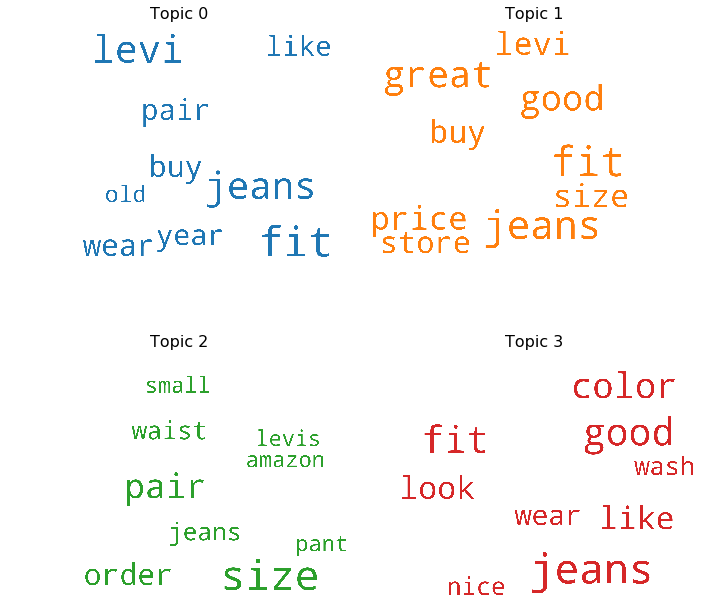

In [101]:
word_plot(topics_lda)

In [49]:
# Transforming an individual sentence
text = reviews_test_lda.comments.iloc[0]
x = lda.transform(vectorizer.transform([text]))#[0]
print(x)

[[0.08333391 0.08344722 0.08333484 0.74988403]]


In [240]:
reviews_test_lda1

,title,rating,date,categorie,comments,product_option,len_review,dominent_topic,topic_0_perc,topic_1_perc,topic_2_perc,topic_3_perc
0,shoulder bag,4,2019-05-22,Bag,Give 4 stars because order at the price 37 but...,Pink:,66,0,0.514012,0.051050,0.383466,0.051472
1,shoulder bag,5,2019-07-18,Bag,Ordered at a discount of 10 baht per piece. It...,Black,167,2,0.374940,0.027780,0.568871,0.028409
2,shoulder bag,5,2019-07-02,Bag,"Small, cute, compact, good But the sash looks ...",Tau,150,2,0.238959,0.154574,0.573252,0.033215
3,shoulder bag,1,2018-12-15,Bag,The size is not as large as it is down. The st...,Black,135,2,0.324446,0.041668,0.592092,0.041794
4,shoulder bag,1,2019-07-24,Bag,The product is compared to the price. Okay. Se...,Black,302,0,0.836123,0.139297,0.012629,0.011951
5,shoulder bag,4,2019-04-23,Bag,Beautiful work Sewing Good compact Suitable fo...,Black,111,2,0.032568,0.163349,0.770528,0.033555
6,shoulder bag,4,2019-07-18,Bag,Worth the price ordered When holding the bag S...,Red,116,2,0.263395,0.028081,0.680189,0.028335
7,shoulder bag,5,2019-08-10,Bag,This bag is like a shoulder bag. Colorful shap...,pink,262,2,0.019925,0.019287,0.861609,0.099180
8,shoulder bag,4,2018-12-19,Bag,"Very nice, but a little crumbling.",pink,34,2,0.086079,0.083337,0.747247,0.083337
9,shoulder bag,5,2019-08-13,Bag,"Beautiful, cheap, very worthwhile. ðŸ‘ðŸ‘ðŸ‘...",Red,531,2,0.015851,0.016563,0.523742,0.443844


In [50]:
reviews_test_lda.comments.iloc[0]

'Very nice, but a little crumbling.'

In [51]:
reviews_test_lda

,title,rating,date,categorie,comments,product_option,len_review,dominent_topic,topic_0_perc,topic_1_perc,topic_2_perc,topic_3_perc
0,shoulder bag,4,2018-12-19,Bag,"Very nice, but a little crumbling.",pink,34,3,0.083334,0.083447,0.083335,0.749884
1,shoulder bag,5,2019-06-23,Bag,"Cute, cute",Gray,10,3,0.083334,0.083334,0.083334,0.749999
2,shoulder bag,5,2019-06-07,Bag,UT to the hospital for me,Black,25,0,0.250000,0.250000,0.250000,0.250000
3,shoulder bag,5,2019-08-15,Bag,"Very good, reed and reed. Reed",pink,30,1,0.055403,0.844596,0.050000,0.050000
4,shoulder bag,5,2019-08-15,Bag,Like a reed hatchback Reed,Gray,26,1,0.062500,0.562515,0.062500,0.312484
5,shoulder bag,3,2019-07-12,Bag,Price 10 baht,brown,13,3,0.083333,0.084160,0.083334,0.749173
6,shoulder bag,5,2019-07-15,Bag,So beautiful Other,Black,18,1,0.125000,0.615266,0.125001,0.134733
7,shoulder bag,3,2019-08-22,Bag,"Delivery is not complete, 2 pieces are missing",Black,46,1,0.085670,0.745430,0.085547,0.083352
8,shoulder bag,5,2019-08-16,Bag,Considered to be very good.,Black,27,0,0.415398,0.084770,0.085090,0.414742
9,shoulder bag,5,2019-05-28,Bag,very pretty,Black,11,3,0.125001,0.125002,0.125002,0.624995


In [52]:
topics_lda_df

,topic,good,quality,product,value,delivery,service,fast,shop,money,...,time,item,receive,like,bag,worth,cute,baht,suitable,small
0,0,5017.671074,1299.272394,1284.243897,1150.220011,777.406440,682.227871,562.571682,276.353454,242.800894,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,1,538.799674,0.000000,1192.174158,0.000000,512.661028,0.000000,451.898037,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,2,0.000000,0.000000,170.338097,0.000000,0.000000,0.000000,0.000000,227.124020,0.000000,...,158.819571,151.221402,95.359887,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,527.217774,484.225002,299.335835,294.225223,262.226834,232.215601,226.237538


#### writing as csv

In [90]:
topics_lda_df.to_csv('/home/gpu1/work_space/disk3_work_space3/CRM_Topic_models/outputs/topics_and_its_word_perc.csv',index = False)
reviews_test_lda.to_csv('/home/gpu1/work_space/disk3_work_space3/CRM_Topic_models/outputs/reviews_and_its_topic_perc.csv',index = False)

## Model Selection

In [134]:
# Sklearn
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV

In [143]:
# Latent Dirichlet Allocation Model
lda = LatentDirichletAllocation(n_components=NUM_TOPICS, max_iter=10, learning_method='online',verbose=True,mean_change_tol=.1,
                               random_state=46)
# lda = LatentDirichletAllocation(n_components=NUM_TOPICS, max_iter=100, learning_method='batch',verbose=False)
# data_lda = lda.fit_transform(data_vectorized)

In [138]:
model = GridSearchCV(cv=None, error_score='raise',
       estimator= LatentDirichletAllocation(batch_size=10, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7, learning_method=None,
             learning_offset=2.0, max_doc_update_iter=100, max_iter=10,
             mean_change_tol=0.001, n_components=5, n_jobs=-1,
              perp_tol=0.1, random_state=None,
             topic_word_prior=None, total_samples=1000000.0, verbose=0),
        iid=True, n_jobs=1,
       param_grid={'n_topics': [4, 5, 6, 8], 'learning_decay': [0.5, 0.7, 0.9],'mean_change_tol': [.1,.01,.001]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [139]:
model.fit(data_vectorized)

ValueError: Invalid parameter n_topics for estimator LatentDirichletAllocation(batch_size=10, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.5,
                          learning_method=None, learning_offset=2.0,
                          max_doc_update_iter=100, max_iter=10,
                          mean_change_tol=0.1, n_components=5, n_jobs=-1,
                          perp_tol=0.1, random_state=None,
                          topic_word_prior=None, total_samples=1000000.0,
                          verbose=0). Check the list of available parameters with `estimator.get_params().keys()`.

In [144]:
# Define Search Param
search_params = {'n_components': [4, 5, 6, 8], 'learning_decay': [.1,.5, .7, .9],'mean_change_tol': [.1,.01,.001]}

# Init the Model
# lda = LatentDirichletAllocation()

# Init Grid Search Class
model = GridSearchCV(lda, param_grid=search_params)

# Do the Grid Search
model.fit(data_vectorized)

iteration: 1 of max_iter: 10
iteration: 2 of max_iter: 10
iteration: 3 of max_iter: 10
iteration: 4 of max_iter: 10
iteration: 5 of max_iter: 10
iteration: 6 of max_iter: 10
iteration: 7 of max_iter: 10
iteration: 8 of max_iter: 10
iteration: 9 of max_iter: 10
iteration: 10 of max_iter: 10
iteration: 1 of max_iter: 10
iteration: 2 of max_iter: 10
iteration: 3 of max_iter: 10
iteration: 4 of max_iter: 10
iteration: 5 of max_iter: 10
iteration: 6 of max_iter: 10
iteration: 7 of max_iter: 10
iteration: 8 of max_iter: 10
iteration: 9 of max_iter: 10
iteration: 10 of max_iter: 10
iteration: 1 of max_iter: 10
iteration: 2 of max_iter: 10
iteration: 3 of max_iter: 10
iteration: 4 of max_iter: 10
iteration: 5 of max_iter: 10
iteration: 6 of max_iter: 10
iteration: 7 of max_iter: 10
iteration: 8 of max_iter: 10
iteration: 9 of max_iter: 10
iteration: 10 of max_iter: 10
iteration: 1 of max_iter: 10
iteration: 2 of max_iter: 10
iteration: 3 of max_iter: 10
iteration: 4 of max_iter: 10
iteration: 

iteration: 3 of max_iter: 10
iteration: 4 of max_iter: 10
iteration: 5 of max_iter: 10
iteration: 6 of max_iter: 10
iteration: 7 of max_iter: 10
iteration: 8 of max_iter: 10
iteration: 9 of max_iter: 10
iteration: 10 of max_iter: 10
iteration: 1 of max_iter: 10
iteration: 2 of max_iter: 10
iteration: 3 of max_iter: 10
iteration: 4 of max_iter: 10
iteration: 5 of max_iter: 10
iteration: 6 of max_iter: 10
iteration: 7 of max_iter: 10
iteration: 8 of max_iter: 10
iteration: 9 of max_iter: 10
iteration: 10 of max_iter: 10
iteration: 1 of max_iter: 10
iteration: 2 of max_iter: 10
iteration: 3 of max_iter: 10
iteration: 4 of max_iter: 10
iteration: 5 of max_iter: 10
iteration: 6 of max_iter: 10
iteration: 7 of max_iter: 10
iteration: 8 of max_iter: 10
iteration: 9 of max_iter: 10
iteration: 10 of max_iter: 10
iteration: 1 of max_iter: 10
iteration: 2 of max_iter: 10
iteration: 3 of max_iter: 10
iteration: 4 of max_iter: 10
iteration: 5 of max_iter: 10
iteration: 6 of max_iter: 10
iteration: 

iteration: 5 of max_iter: 10
iteration: 6 of max_iter: 10
iteration: 7 of max_iter: 10
iteration: 8 of max_iter: 10
iteration: 9 of max_iter: 10
iteration: 10 of max_iter: 10
iteration: 1 of max_iter: 10
iteration: 2 of max_iter: 10
iteration: 3 of max_iter: 10
iteration: 4 of max_iter: 10
iteration: 5 of max_iter: 10
iteration: 6 of max_iter: 10
iteration: 7 of max_iter: 10
iteration: 8 of max_iter: 10
iteration: 9 of max_iter: 10
iteration: 10 of max_iter: 10
iteration: 1 of max_iter: 10
iteration: 2 of max_iter: 10
iteration: 3 of max_iter: 10
iteration: 4 of max_iter: 10
iteration: 5 of max_iter: 10
iteration: 6 of max_iter: 10
iteration: 7 of max_iter: 10
iteration: 8 of max_iter: 10
iteration: 9 of max_iter: 10
iteration: 10 of max_iter: 10
iteration: 1 of max_iter: 10
iteration: 2 of max_iter: 10
iteration: 3 of max_iter: 10
iteration: 4 of max_iter: 10
iteration: 5 of max_iter: 10
iteration: 6 of max_iter: 10
iteration: 7 of max_iter: 10
iteration: 8 of max_iter: 10
iteration: 

iteration: 7 of max_iter: 10
iteration: 8 of max_iter: 10
iteration: 9 of max_iter: 10
iteration: 10 of max_iter: 10
iteration: 1 of max_iter: 10
iteration: 2 of max_iter: 10
iteration: 3 of max_iter: 10
iteration: 4 of max_iter: 10
iteration: 5 of max_iter: 10
iteration: 6 of max_iter: 10
iteration: 7 of max_iter: 10
iteration: 8 of max_iter: 10
iteration: 9 of max_iter: 10
iteration: 10 of max_iter: 10
iteration: 1 of max_iter: 10
iteration: 2 of max_iter: 10
iteration: 3 of max_iter: 10
iteration: 4 of max_iter: 10
iteration: 5 of max_iter: 10
iteration: 6 of max_iter: 10
iteration: 7 of max_iter: 10
iteration: 8 of max_iter: 10
iteration: 9 of max_iter: 10
iteration: 10 of max_iter: 10
iteration: 1 of max_iter: 10
iteration: 2 of max_iter: 10
iteration: 3 of max_iter: 10
iteration: 4 of max_iter: 10
iteration: 5 of max_iter: 10
iteration: 6 of max_iter: 10
iteration: 7 of max_iter: 10
iteration: 8 of max_iter: 10
iteration: 9 of max_iter: 10
iteration: 10 of max_iter: 10
iteration:

iteration: 10 of max_iter: 10
iteration: 1 of max_iter: 10
iteration: 2 of max_iter: 10
iteration: 3 of max_iter: 10
iteration: 4 of max_iter: 10
iteration: 5 of max_iter: 10
iteration: 6 of max_iter: 10
iteration: 7 of max_iter: 10
iteration: 8 of max_iter: 10
iteration: 9 of max_iter: 10
iteration: 10 of max_iter: 10
iteration: 1 of max_iter: 10
iteration: 2 of max_iter: 10
iteration: 3 of max_iter: 10
iteration: 4 of max_iter: 10
iteration: 5 of max_iter: 10
iteration: 6 of max_iter: 10
iteration: 7 of max_iter: 10
iteration: 8 of max_iter: 10
iteration: 9 of max_iter: 10
iteration: 10 of max_iter: 10
iteration: 1 of max_iter: 10
iteration: 2 of max_iter: 10
iteration: 3 of max_iter: 10
iteration: 4 of max_iter: 10
iteration: 5 of max_iter: 10
iteration: 6 of max_iter: 10
iteration: 7 of max_iter: 10
iteration: 8 of max_iter: 10
iteration: 9 of max_iter: 10
iteration: 10 of max_iter: 10
iteration: 1 of max_iter: 10
iteration: 2 of max_iter: 10
iteration: 3 of max_iter: 10
iteration:

iteration: 3 of max_iter: 10
iteration: 4 of max_iter: 10
iteration: 5 of max_iter: 10
iteration: 6 of max_iter: 10
iteration: 7 of max_iter: 10
iteration: 8 of max_iter: 10
iteration: 9 of max_iter: 10
iteration: 10 of max_iter: 10
iteration: 1 of max_iter: 10
iteration: 2 of max_iter: 10
iteration: 3 of max_iter: 10
iteration: 4 of max_iter: 10
iteration: 5 of max_iter: 10
iteration: 6 of max_iter: 10
iteration: 7 of max_iter: 10
iteration: 8 of max_iter: 10
iteration: 9 of max_iter: 10
iteration: 10 of max_iter: 10
iteration: 1 of max_iter: 10
iteration: 2 of max_iter: 10
iteration: 3 of max_iter: 10
iteration: 4 of max_iter: 10
iteration: 5 of max_iter: 10
iteration: 6 of max_iter: 10
iteration: 7 of max_iter: 10
iteration: 8 of max_iter: 10
iteration: 9 of max_iter: 10
iteration: 10 of max_iter: 10
iteration: 1 of max_iter: 10
iteration: 2 of max_iter: 10
iteration: 3 of max_iter: 10
iteration: 4 of max_iter: 10
iteration: 5 of max_iter: 10
iteration: 6 of max_iter: 10
iteration: 

GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=LatentDirichletAllocation(batch_size=128,
                                                 doc_topic_prior=None,
                                                 evaluate_every=-1,
                                                 learning_decay=0.7,
                                                 learning_method='online',
                                                 learning_offset=10.0,
                                                 max_doc_update_iter=100,
                                                 max_iter=10,
                                                 mean_change_tol=0.1,
                                                 n_components=10, n_jobs=None,
                                                 perp_tol=0.1, random_state=46,
                                                 topic_word_prior=None,
                                                 total_samples=1000000.0,
             

In [145]:
# Best Model
best_lda_model = model.best_estimator_

# Model Parameters
print("Best Model's Params: ", model.best_params_)

# Log Likelihood Score
print("Best Log Likelihood Score: ", model.best_score_)

# Perplexity
print("Model Perplexity: ", best_lda_model.perplexity(data_vectorized))

Best Model's Params:  {'learning_decay': 0.5, 'mean_change_tol': 0.01, 'n_components': 4}
Best Log Likelihood Score:  -66087.94021233183
Model Perplexity:  215.63130855519688


# Plots 

In [53]:
#reviews_test_lda = reviews[(reviews.len_review>=max_limit) | (reviews.len_review<s_limit)]
reviews_test_lda = reviews_ms.sample(2000)
reviews_test_lda.shape
reviews_test_lda['index1'] = range(len(reviews_test_lda))

dominent_topic_list = []
topic_detail = pd.DataFrame()
topic_detail['index1'] = reviews_test_lda.index1
for i in range(0,NUM_TOPICS):
    topic_detail['topic_'+str(i)+'_perc'] = 0.0


for i in tqdm(range(len(reviews_test_lda))):
    text = reviews_test_lda.comments.iloc[i]
    x = lda.transform(vectorizer.transform([text]))[0]
    y = pd.Series(x)
    for k in range(len(y)):
        topic_detail.loc[topic_detail.index1==i,'topic_'+str(k)+'_perc'] = y[k]
    y1 = y[y==max(y)].index[0]
    dominent_topic_list.append(y1)
    
reviews_test_lda['dominent_topic'] = dominent_topic_list
reviews_test_lda = reviews_test_lda.merge(topic_detail,on='index1',how='left')
del reviews_test_lda['index1']

100%|██████████| 2000/2000 [00:11<00:00, 169.72it/s]


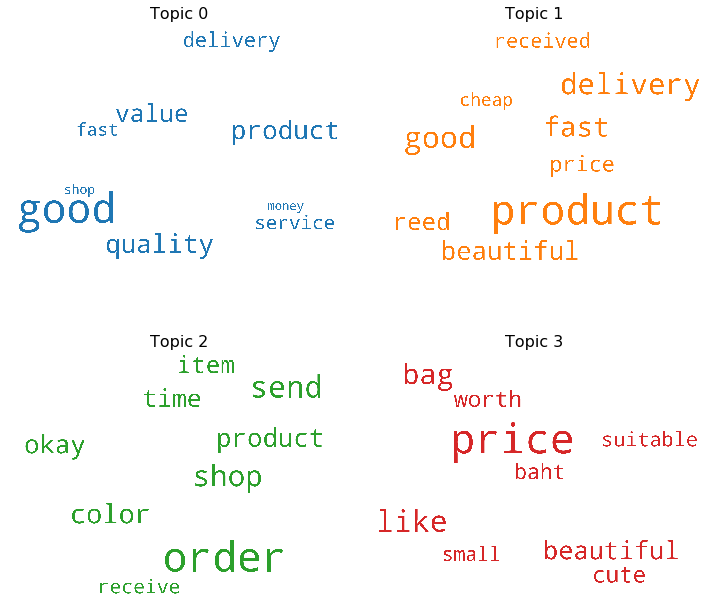

In [54]:
word_plot(topics_lda)

In [55]:
reviews_test_lda[reviews_test_lda.rating==1]

,title,rating,date,categorie,comments,product_option,len_review,dominent_topic,topic_0_perc,topic_1_perc,topic_2_perc,topic_3_perc
1,shoulder bag,1,2019-08-18,Bag,Complete payment according to the amount repor...,Red,280,2,0.063989,0.416964,0.456536,0.062512
16,shoulder bag,1,2019-08-15,Bag,"Order red, brown color ðŸ˜¥",Red,27,2,0.050000,0.050001,0.849548,0.050451
20,shoulder bag,1,2019-07-27,Bag,Not the color as ordered,Red,24,2,0.083334,0.083334,0.748350,0.084982
21,Mini shoulder bag,1,2018-08-16,Bag,The quality of the product is very poor.,brown,40,0,0.500692,0.068448,0.368335,0.062526
41,shoulder bag,1,2019-08-18,Bag,Did not receive the product,pink,27,1,0.084927,0.743144,0.088583,0.083346
64,Mini shoulder bag,1,2019-06-22,Bag,The product is not as beautiful as in the pict...,pink,166,3,0.218866,0.029723,0.025672,0.725739
66,shoulder bag,1,2019-04-30,Bag,Do not match the cover .. Order gray can be ve...,Gray,64,2,0.041726,0.041668,0.874631,0.041976
72,shoulder bag,1,2019-08-16,Bag,Not in color,Red,12,2,0.125000,0.125001,0.618730,0.131269
77,shoulder bag,1,2019-07-24,Bag,Order brown color in red.,brown,25,2,0.050000,0.050001,0.849548,0.050451
79,shoulder bag,1,2019-05-28,Bag,"Order another, send another form, responsible ...",Red,154,2,0.031251,0.301734,0.633665,0.033351


#### plot of rating distribution in each topics

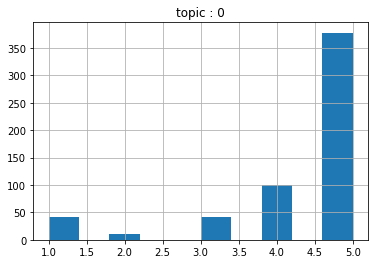

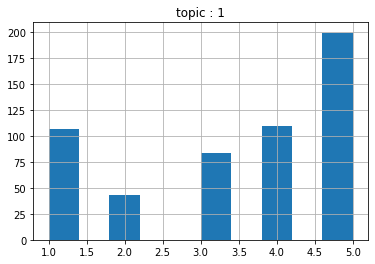

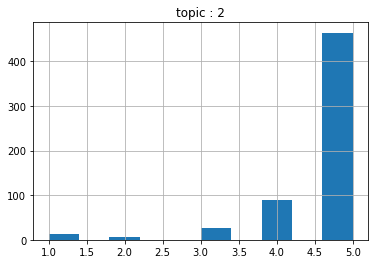

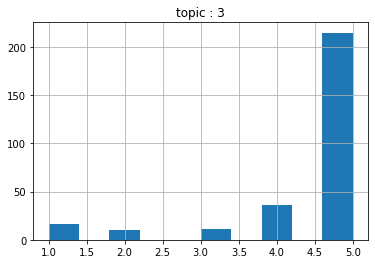

In [94]:
for t in range(0,NUM_TOPICS):
    tmp = reviews_test_lda[reviews_test_lda.dominent_topic==t]
    tmp.rating.hist()
    plt.title('topic : '+str(t))
    plt.show()

#### plot of topic distribution in each ratings

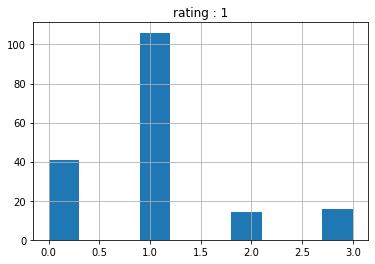

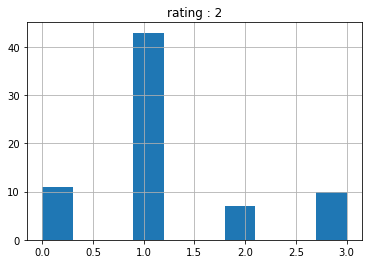

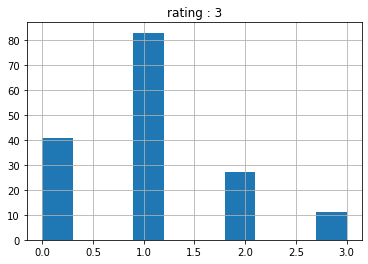

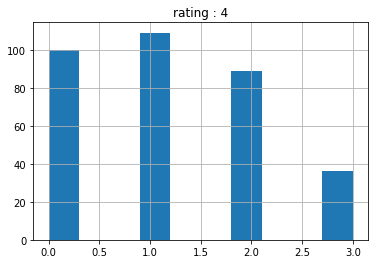

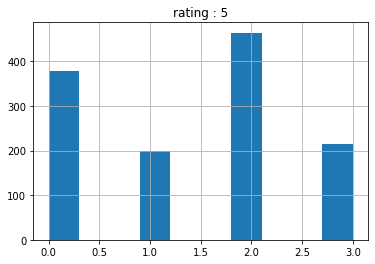

In [95]:

for t in range(1,6):
    tmp = reviews_test_lda[reviews_test_lda.rating==t]
    tmp.dominent_topic.hist()
    plt.title('rating : '+str(t))
    plt.show()

#### topic distribution in each catogory of bag

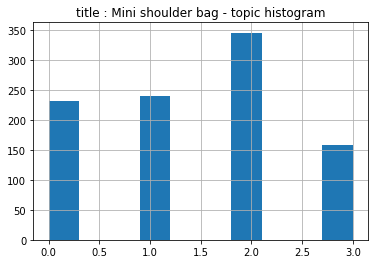

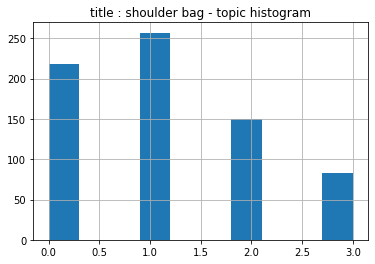

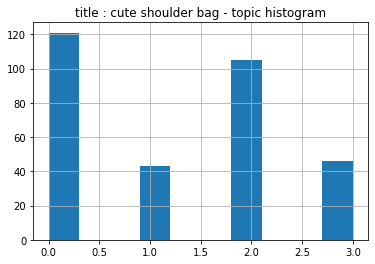

In [96]:
title = reviews_test_lda.title.unique()
for t in title:
    tmp = reviews_test_lda[reviews_test_lda.title==t]
    tmp.dominent_topic.hist()
    plt.title('title : '+str(t)+' - topic histogram')
    plt.show()

#### rating distribution in each catogory of bags

In [56]:
reviews_test_lda.title.value_counts()

Mini shoulder bag    967
shoulder bag         717
cute shoulder bag    316
Name: title, dtype: int64

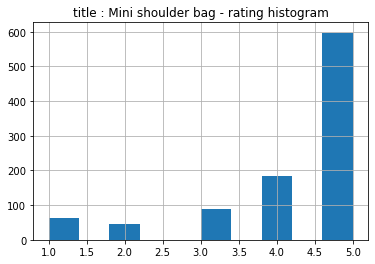

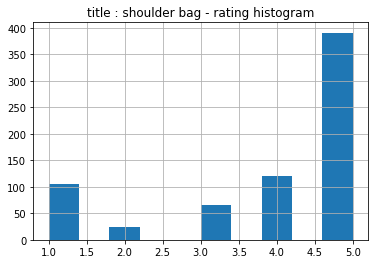

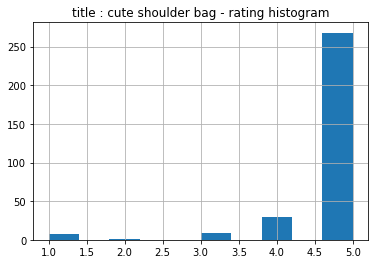

In [98]:
title = reviews_test_lda.title.unique()
for t in title:
    tmp = reviews_test_lda[reviews_test_lda.title==t]
    tmp.rating.hist()
    plt.title('title : '+str(t)+' - rating histogram')
    plt.show()

#### catogory of bag distribution in each topics

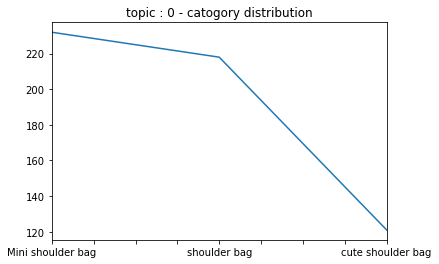

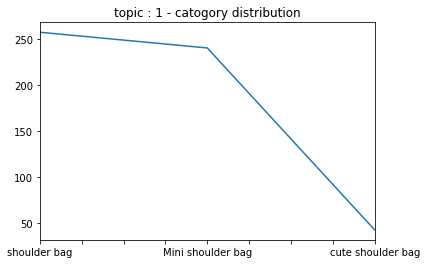

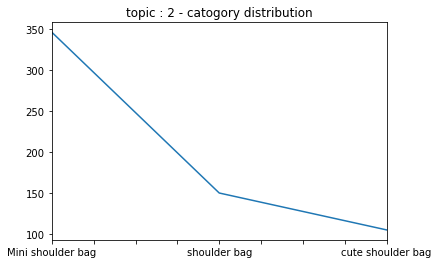

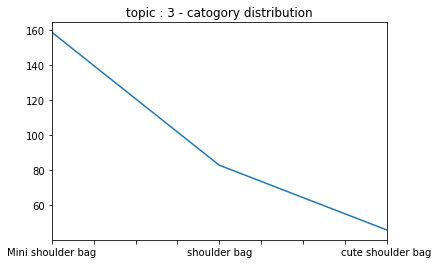

In [99]:

for t in range(0,NUM_TOPICS):
    tmp = reviews_test_lda[reviews_test_lda.dominent_topic==t]
    tmp.title.value_counts().plot()
    plt.title('topic : '+str(t)+' - catogory distribution')
    plt.show()

#### catogory of bag distribution in each ratings

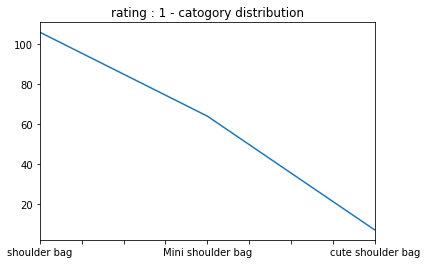

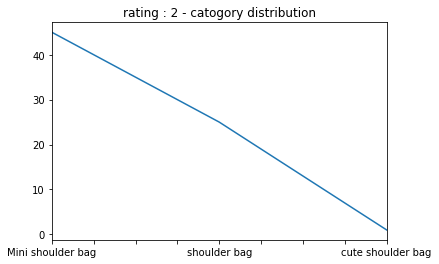

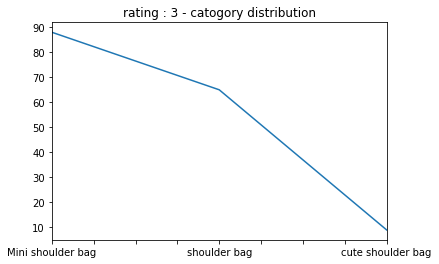

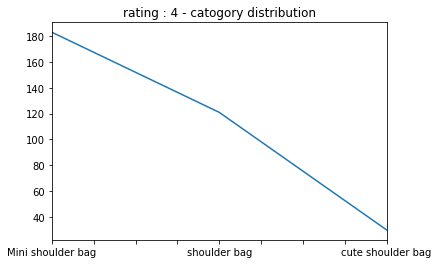

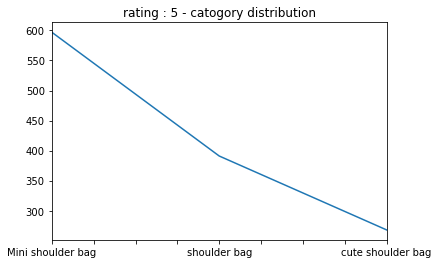

In [100]:

for t in range(1,6):
    tmp = reviews_test_lda[reviews_test_lda.rating==t]
    tmp.title.value_counts().plot()
    plt.title('rating : '+str(t)+' - catogory distribution')
    plt.show()

#### plot of amount of items in each category

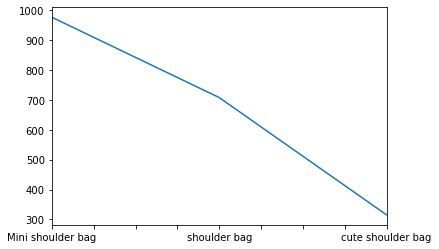

In [101]:
reviews_test_lda.title.value_counts().plot()

In [102]:
reviews_test_lda.title.value_counts()

Mini shoulder bag    977
shoulder bag         708
cute shoulder bag    315
Name: title, dtype: int64

## Our findings :

- mainly 4 topics are in the customer review thery are :
 - quality, beauty, price, delivery [topic-0, topic-1, topic-2, topic-3]
- we found that as per rating distribution , most of rating 5 are done in topic-0 , and rating 1 is to topic-1
- most topic-1 are in rating 5 but it contains comparitivly large amount of rating 1
- most topic-0 are in rating 5.

- out of 309 'cute shoulder bag' 250 above reviews give 5 star rating , and almost 110 peaple talking about its quality. then price.
- out of 754 'shoulder bag' 450+ reviews give 5 stars and 100+ reviews give 1 star (~13%) . and almost 325 peaple talking about its beauty, then quality

# For individual model and bokeh visualisation

In [232]:
topics_lda_df

,topic,good,quality,product,value,delivery,service,fast,shop,money,...,time,item,receive,like,bag,worth,cute,baht,suitable,small
0,0,5017.671074,1299.272394,1284.243897,1150.220011,777.406440,682.227871,562.571682,276.353454,242.800894,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,1,538.799674,0.000000,1192.174158,0.000000,512.661028,0.000000,451.898037,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,2,0.000000,0.000000,170.338097,0.000000,0.000000,0.000000,0.000000,227.124020,0.000000,...,158.819571,151.221402,95.359887,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,527.217774,484.225002,299.335835,294.225223,262.226834,232.215601,226.237538


In [225]:
topic_keys

[('price', 1201.2297708009623),
 ('like', 527.2177737486563),
 ('bag', 484.2250021845216),
 ('beautiful', 375.3389510160114),
 ('worth', 299.33583461204745),
 ('cute', 294.2252228997858),
 ('baht', 262.22683368828945),
 ('suitable', 232.2156007469277),
 ('small', 226.23753774375996)]

In [231]:
topic[20]

188.99261221442939

In [171]:
# Creating a spaCy object
nlp = spacy.load('en_core_web_lg')

punctuations = string.punctuation
stopwords = list(STOP_WORDS)

# Parser for reviews
parser = English()
def spacy_tokenizer(sentence):
    mytokens = parser(sentence)
    mytokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]
    mytokens = [ word for word in mytokens if word not in stopwords and word not in punctuations ]
    mytokens = " ".join([i for i in mytokens])
    return mytokens

# Functions for printing keywords for each topic
def selected_topics(model, vectorizer, top_n=10):
    topics = []
    for idx, topic in enumerate(model.components_):
        #print("Topic %d:" % (idx))
        topic_keys = [(vectorizer.get_feature_names()[i], topic[i]) for i in topic.argsort()[:-top_n - 0:-1]]
        topics.append((idx,topic_keys))
        #print([(vectorizer.get_feature_names()[i], topic[i]) for i in topic.argsort()[:-top_n - 0:-1]]) 
    return topics

##################################################################################################

def lda_finder(reviews_ms,NUM_TOPICS):
    
    reviews_ms=reviews_ms.drop_duplicates()

    reviews_ms.comments=reviews_ms.comments.astype(str)
    reviews_ms['len_review']=reviews_ms.comments.apply(len)
    reviews_ms.comments=reviews_ms.comments.apply(lambda x: x.replace('👍','good '))

    s_limit=50
    max_limit=1300
    reviews=reviews_ms.loc[(reviews_ms.len_review>=s_limit) & (reviews_ms.len_review<max_limit),:]


    ## lemmetization, stopword remove, punctuation remove etc
    tqdm.pandas()
    reviews["processed_description"] = reviews["comments"].progress_apply(spacy_tokenizer)
    #reviews["processed_description"] = reviews["comments"].apply(spacy_tokenizer)

    # Creating a vectorizer
    vectorizer = CountVectorizer(min_df=0.005, max_df=0.85, stop_words='english', lowercase=True, token_pattern='[a-zA-Z\-][a-zA-Z\-]{2,}')
    data_vectorized = vectorizer.fit_transform(reviews["processed_description"])

    #NUM_TOPICS = 4
    
    SOME_FIXED_SEED = 46

    # before training/inference:
    np.random.seed(SOME_FIXED_SEED)
    
    # Latent Dirichlet Allocation Model
    #lda = LatentDirichletAllocation(n_components=NUM_TOPICS, max_iter=50, learning_method='online',verbose=True)
    lda = LatentDirichletAllocation(n_components=NUM_TOPICS, max_iter=50, learning_method='batch',verbose=False)#,random_state=1)
    data_lda = lda.fit_transform(data_vectorized)

    # Keywords for topics clustered by Latent Dirichlet Allocation
    #print("LDA Model:")
    topics_lda = selected_topics(lda, vectorizer)

    ## topics df with its words - distribution df
    topics_lda_df  = pd.DataFrame()
    i1 = [ t[0] for t in topics_lda]
    i2 = []
    for t in topics_lda:
        for t1 in t[1]:
            i2.append(t1[0])

    topics_lda_df['topic'] = i1
    for i in i2:
        topics_lda_df[i] = 0.0

    for i,t in enumerate(topics_lda):
        for t1 in t[1]:
            topics_lda_df.loc[topics_lda_df.topic==i,t1[0]]=t1[1]

    ## topic precentage in all reviews
    reviews_test_lda = reviews_ms.copy()#[(reviews_ms.len_review>=max_limit) | (reviews_ms.len_review<s_limit)]
    reviews_test_lda['index1'] = range(len(reviews_test_lda))

    dominent_topic_list = []
    topic_detail = pd.DataFrame()
    topic_detail['index1'] = reviews_test_lda.index1
    for i in range(0,NUM_TOPICS):
        topic_detail['topic_'+str(i)+'_perc'] = 0.0


    for i in tqdm(range(len(reviews_test_lda))):
        text = reviews_test_lda.comments.iloc[i]
        x = lda.transform(vectorizer.transform([text]))[0]
        y = pd.Series(x)
        for k in range(len(y)):
            topic_detail.loc[topic_detail.index1==i,'topic_'+str(k)+'_perc'] = y[k]
        y1 = y[y==max(y)].index[0]
        dominent_topic_list.append(y1)

    reviews_test_lda['dominent_topic'] = dominent_topic_list
    reviews_test_lda = reviews_test_lda.merge(topic_detail,on='index1',how='left')
    del reviews_test_lda['index1']

    return lda, topics_lda, topics_lda_df, reviews_test_lda, data_vectorized, vectorizer

In [5]:
s1 = "I saw this in a Hammacher Schlemmer catalog for $99.95 plus shipping of $16.95. What a joke those prices are. are. I just love Amazon and appreciate the reviewer who confirmed that it is basically the one in the catalog. The label and packaging say it is made by Isonic.I also appreciate the reviewers who warned me about emptying it without allowing any water to leak into the controls. The instructions also say this. As I am carefully dumping it out quickly and in the direction of the lid-no problem yet. This little gem works WONDERS on my husbands' oily eye glasses, and my little reading glasses. I did add some glasses cleaner to the water-not much. Seems an adequate job on jewelry too. Look forward to trying per instructions to cleaning some oxidized sliver jewelry. Will update if that works. Thank you, Amazon."
s2 = "I just love Amazon and appreciate the reviewer who confirmed that it is basically the one in the catalog"
s1.find(s2)

115

In [8]:
len(s1),len(s2)

(823, 104)

In [6]:
s1[s1.find(s2):len(s2)]

''

In [193]:
reviews_ms.title.unique()

array(['shoulder bag', 'Mini shoulder bag', 'cute shoulder bag'],
      dtype=object)

In [194]:
reviews_ms1 = reviews_ms.copy()
lda1, topics_lda1, topics_lda_df1, reviews_test_lda1, data_vectorized1, vectorizer1 = lda_finder(reviews_ms1,NUM_TOPICS=4)

100%|██████████| 3104/3104 [00:18<00:00, 168.86it/s]


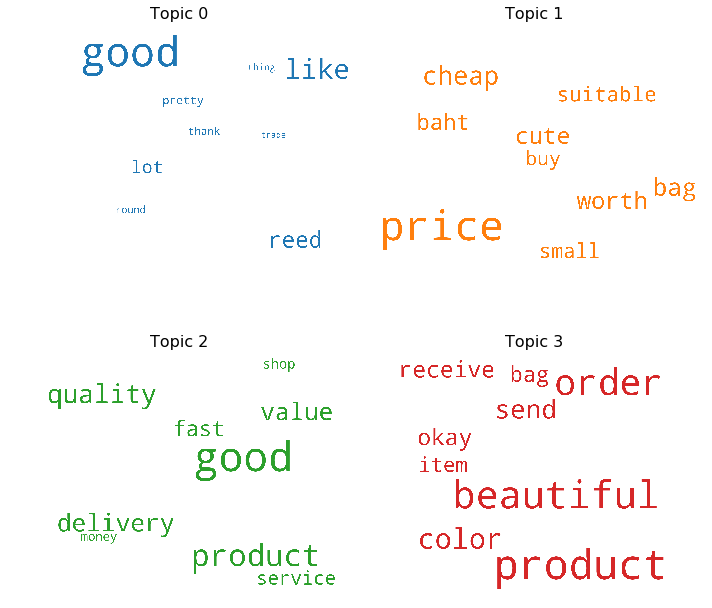

In [195]:
word_plot(topics_lda1)

### shoulder bag

In [196]:
reviews_ms1 = reviews_ms[reviews_ms.title=='shoulder bag']
lda1, topics_lda1, topics_lda_df1, reviews_test_lda1, data_vectorized1, vectorizer1 = lda_finder(reviews_ms1,NUM_TOPICS=4)

100%|██████████| 1114/1114 [00:06<00:00, 166.06it/s]


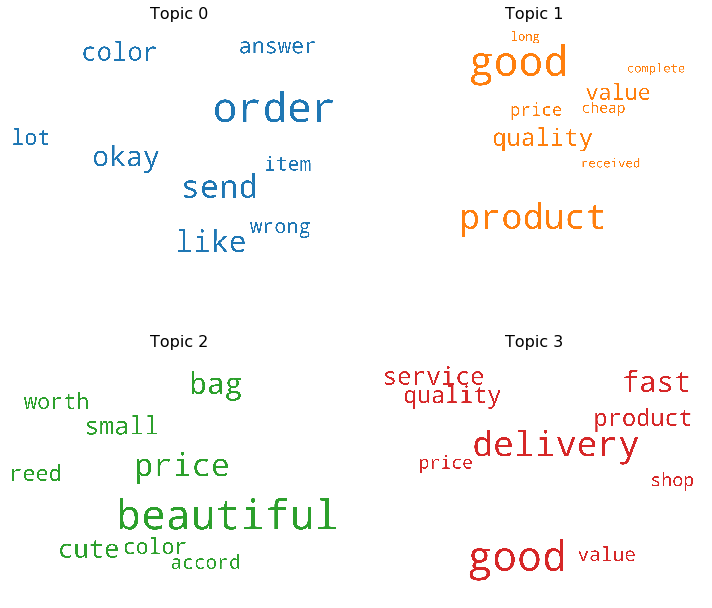

In [197]:
word_plot(topics_lda1)

In [ ]:
topics_lda_df1.to_csv('/home/gpu1/work_space/disk3_work_space3/CRM_Topic_models/outputs/topics_and_its_word_perc_shoulder_bag.csv',index = False)
reviews_test_lda1.to_csv('/home/gpu1/work_space/disk3_work_space3/CRM_Topic_models/outputs/reviews_and_its_topic_perc_shoulder_bag.csv',index = False)

In [62]:
reviews_test_lda1

,title,rating,date,categorie,comments,product_option,len_review,dominent_topic,topic_0_perc,topic_1_perc,topic_2_perc,topic_3_perc
0,shoulder bag,4,2019-05-22,Bag,Give 4 stars because order at the price 37 but...,Pink:,66,0,0.845734,0.051112,0.052159,0.050996
1,shoulder bag,5,2019-07-18,Bag,Ordered at a discount of 10 baht per piece. It...,Black,167,0,0.914251,0.029209,0.028533,0.028007
2,shoulder bag,5,2019-07-02,Bag,"Small, cute, compact, good But the sash looks ...",Tau,150,2,0.032028,0.031711,0.902996,0.033265
3,shoulder bag,1,2018-12-15,Bag,The size is not as large as it is down. The st...,Black,135,0,0.868313,0.042494,0.045652,0.043540
4,shoulder bag,1,2019-07-24,Bag,The product is compared to the price. Okay. Se...,Black,302,0,0.531077,0.443421,0.013840,0.011662
5,shoulder bag,4,2019-04-23,Bag,Beautiful work Sewing Good compact Suitable fo...,Black,111,2,0.204557,0.032293,0.728391,0.034758
6,shoulder bag,4,2019-07-18,Bag,Worth the price ordered When holding the bag S...,Red,116,0,0.662231,0.279906,0.029461,0.028403
7,shoulder bag,5,2019-08-10,Bag,This bag is like a shoulder bag. Colorful shap...,pink,262,2,0.318358,0.019426,0.642507,0.019709
8,shoulder bag,4,2018-12-19,Bag,"Very nice, but a little crumbling.",pink,34,2,0.085887,0.085545,0.745231,0.083338
9,shoulder bag,5,2019-08-13,Bag,"Beautiful, cheap, very worthwhile. ðŸ‘ðŸ‘ðŸ‘...",Red,531,2,0.015947,0.164420,0.803562,0.016070


In [63]:
reviews_test_lda1.dominent_topic.value_counts()

0    367
2    314
3    300
1    133
Name: dominent_topic, dtype: int64

In [64]:
reviews_test_lda1.rating.value_counts()

5    613
4    186
1    158
3    117
2     40
Name: rating, dtype: int64

### Mini shoulder bag

In [65]:
reviews_ms1 = reviews_ms[reviews_ms.title=='Mini shoulder bag']
lda1, topics_lda1, topics_lda_df1, reviews_test_lda1, data_vectorized1, vectorizer1 = lda_finder(reviews_ms1,NUM_TOPICS)

100%|██████████| 1511/1511 [00:08<00:00, 168.85it/s]


In [66]:
topics_lda_df1.to_csv('/home/gpu1/work_space/disk3_work_space3/CRM_Topic_models/outputs/topics_and_its_word_perc_Mini_shoulder_bag.csv',index = False)
reviews_test_lda1.to_csv('/home/gpu1/work_space/disk3_work_space3/CRM_Topic_models/outputs/reviews_and_its_topic_perc_Mini_shoulder_bag.csv',index = False)

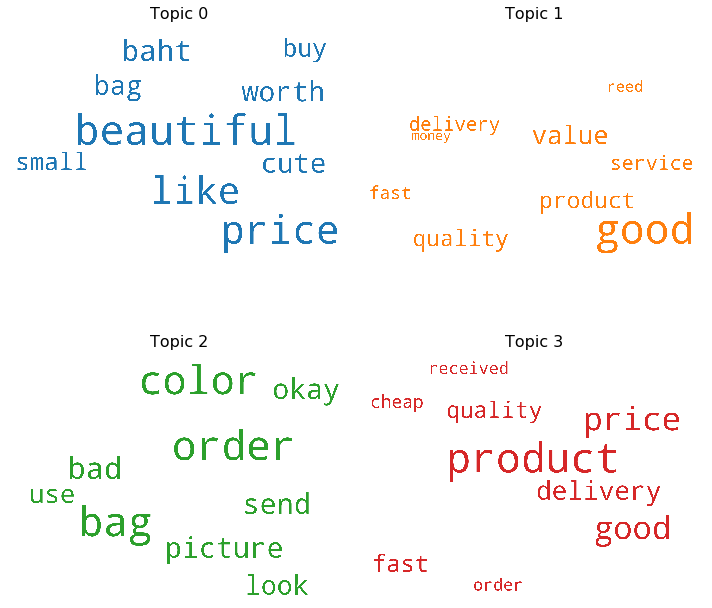

In [67]:
word_plot(topics_lda1)

In [68]:
reviews_test_lda1

,title,rating,date,categorie,comments,product_option,len_review,dominent_topic,topic_0_perc,topic_1_perc,topic_2_perc,topic_3_perc
0,Mini shoulder bag,5,2019-06-29,Bag,The product is shipped quickly. Keep the job n...,brown,424,3,0.238811,0.010991,0.277901,0.472297
1,Mini shoulder bag,1,2019-06-15,Bag,"As a condition, really, shopping, organizing a...",gray,283,0,0.485228,0.021453,0.021705,0.471614
2,Mini shoulder bag,5,2019-06-13,Bag,"Acquired the price of 6 baht, free shipping, g...",pink,197,0,0.424306,0.397577,0.164242,0.013875
3,Mini shoulder bag,2,2019-06-16,Bag,Products delivered on time Very good transport...,pink,222,0,0.355506,0.298365,0.317265,0.028864
4,Mini shoulder bag,4,2019-07-01,Bag,"The price is very cheap, but the movie is very...",pink,221,0,0.571519,0.031252,0.032779,0.364450
5,Mini shoulder bag,4,2019-06-14,Bag,"Considered good value, suitable for the price ...",pink,191,0,0.470242,0.202556,0.308051,0.019151
6,Mini shoulder bag,4,2019-04-03,Bag,Thanks you so much but the picture is not the ...,black,99,2,0.063613,0.062501,0.811047,0.062840
7,Mini shoulder bag,4,2018-10-13,Bag,"Price, good value Good delivery speed",gray,37,1,0.037890,0.700908,0.035715,0.225487
8,Mini shoulder bag,4,2019-07-15,Bag,Product quality is good enough. Ordering at a ...,black,573,3,0.373561,0.112487,0.007594,0.506357
9,Mini shoulder bag,5,2019-07-01,Bag,Imagine then laughing. 55555 Stitching product...,brown,147,2,0.443846,0.022737,0.509292,0.024125


In [69]:
reviews_test_lda1.dominent_topic.value_counts()

1    517
0    421
3    404
2    169
Name: dominent_topic, dtype: int64

In [70]:
reviews_test_lda1.rating.value_counts()

5    937
4    280
3    121
1     99
2     74
Name: rating, dtype: int64

### cute shoulder bag

In [71]:
reviews_ms1 = reviews_ms[reviews_ms.title=='cute shoulder bag']
lda1, topics_lda1, topics_lda_df1, reviews_test_lda1, data_vectorized1, vectorizer1 = lda_finder(reviews_ms1,NUM_TOPICS)

100%|██████████| 479/479 [00:02<00:00, 171.20it/s]


In [72]:
topics_lda_df1.to_csv('/home/gpu1/work_space/disk3_work_space3/CRM_Topic_models/outputs/topics_and_its_word_perc_cute_shoulder_bag.csv',index = False)
reviews_test_lda1.to_csv('/home/gpu1/work_space/disk3_work_space3/CRM_Topic_models/outputs/reviews_and_its_topic_perc_cute_shoulder_bag.csv',index = False)

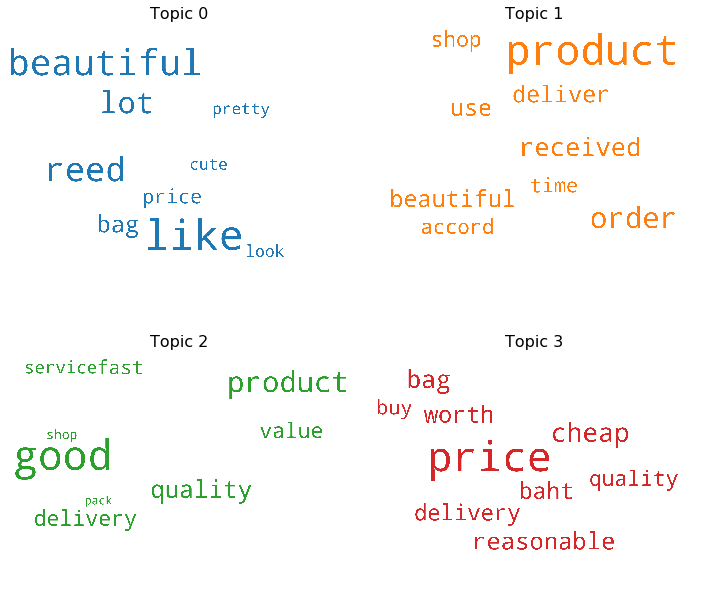

In [73]:
word_plot(topics_lda1)

In [74]:
reviews_test_lda1

,title,rating,date,categorie,comments,product_option,len_review,dominent_topic,topic_0_perc,topic_1_perc,topic_2_perc,topic_3_perc
0,cute shoulder bag,5,2019-06-10,Bag,"Buy now the Fleck cell, leaving 10 baht. Very ...",Black,141,3,0.022368,0.019777,0.025350,0.932505
1,cute shoulder bag,4,2019-06-25,Bag,"The bag is more beautiful than I thought, but ...",Black,199,0,0.582124,0.373784,0.022489,0.021603
2,cute shoulder bag,4,2019-07-10,Bag,Cute bag There are many colors to choose from ...,Gray,145,2,0.018468,0.264629,0.470936,0.245967
3,cute shoulder bag,5,2019-06-21,Bag,Very cute product. May have a slight wrinkles ...,Pink,97,1,0.036984,0.570319,0.353927,0.038770
4,cute shoulder bag,5,2019-06-08,Bag,"Beautiful, beautiful, affordable, good price r...",Black,186,0,0.556298,0.012670,0.219873,0.211158
5,cute shoulder bag,1,2019-06-15,Bag,In many good looking photos But the real produ...,Blue,125,3,0.031345,0.219194,0.256960,0.492501
6,cute shoulder bag,4,2019-06-15,Bag,"Okay products, compared to the price But the e...",Gray,118,0,0.550993,0.026608,0.222194,0.200205
7,cute shoulder bag,4,2019-07-11,Bag,"Reasonable price, shop, delivery, weaver Less ...",Gray,153,3,0.025047,0.345600,0.026716,0.602637
8,cute shoulder bag,5,2019-07-24,Bag,Very good quality Very good value Good transpo...,Black,124,2,0.019194,0.119949,0.842880,0.017977
9,cute shoulder bag,5,2019-06-29,Bag,Transit time is low. Quality according to the ...,Gray,80,3,0.050166,0.249654,0.053459,0.646722


In [75]:
reviews_test_lda1.dominent_topic.value_counts()

2    235
0     87
3     82
1     75
Name: dominent_topic, dtype: int64

In [76]:
reviews_test_lda1.rating.value_counts()

5    406
4     50
3     15
1      7
2      1
Name: rating, dtype: int64

In [77]:
reviews_ms.head()

,title,rating,date,categorie,comments,product_option,len_review
0,shoulder bag,4,2019-05-22,Bag,Give 4 stars because order at the price 37 but...,Pink:,66
1,shoulder bag,5,2019-07-18,Bag,Ordered at a discount of 10 baht per piece. It...,Black,167
2,shoulder bag,5,2019-07-02,Bag,"Small, cute, compact, good But the sash looks ...",Tau,150
3,shoulder bag,1,2018-12-15,Bag,The size is not as large as it is down. The st...,Black,135
4,shoulder bag,1,2019-07-24,Bag,The product is compared to the price. Okay. Se...,Black,302


# Bokeh plotting

In [78]:
topic_distribution = pd.DataFrame(reviews_test_lda1.dominent_topic.value_counts()).reset_index()
topic_distribution.columns = ['index','count']
topic_distribution

,index,count
0,2,235
1,0,87
2,3,82
3,1,75


In [79]:
rating_distribution = pd.DataFrame(reviews_test_lda1.rating.value_counts()).reset_index()
rating_distribution.columns = ['index','count']
rating_distribution

,index,count
0,5,406
1,4,50
2,3,15
3,1,7
4,2,1


In [136]:

def word_plot1(topics):
    cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

    cloud = WordCloud(stopwords=STOP_WORDS,
                      background_color='white',
                      width=2500,
                      height=1800,
                      max_words=10,
                      colormap='tab10',
                      color_func=lambda *args, **kwargs: cols[i],
                      prefer_horizontal=1.0)

    #topics = lda.show_topics(formatted=False)

    fig, axes = plt.subplots(1, 4, figsize=(14,14), sharex=True, sharey=True)

    for i, ax in enumerate(axes.flatten()):
        fig.add_subplot(ax)
        topic_words = dict(topics[i][1])
        cloud.generate_from_frequencies(topic_words, max_font_size=300)
        plt.gca().imshow(cloud)
        plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
        plt.gca().axis('off')


    plt.subplots_adjust(wspace=0, hspace=0)
    plt.axis('off')
    plt.margins(x=0, y=0)
    plt.tight_layout()
    plt.show()

In [1]:
from bokeh.io import output_notebook,show, push_notebook
from bokeh.layouts import widgetbox,column,row
from bokeh.models.widgets import Dropdown,PreText, Select

from bokeh.models import HoverTool
from bokeh.plotting import curdoc,figure
from ipywidgets import interact

from bokeh.models import ColumnDataSource

output_notebook()

Loading BokehJS ...

In [170]:

menu = list(reviews_ms.title.unique())
menu = menu+['all']

def update(category):
    
    if category=='all':
        reviews_ms1 = reviews_ms.copy()
    else:
        reviews_ms1 = reviews_ms[reviews_ms.title==category]
    lda1, topics_lda1, topics_lda_df1, reviews_test_lda1, data_vectorized1, vectorizer1 = lda_finder(reviews_ms1,NUM_TOPICS)
    
    topic_distribution = pd.DataFrame(reviews_test_lda1.dominent_topic.value_counts()).reset_index()
    topic_distribution.columns = ['index','count']
    
    rating_distribution = pd.DataFrame(reviews_test_lda1.rating.value_counts()).reset_index()
    rating_distribution.columns = ['index','count']
    
    source_topic_distribution.data = source_topic_distribution.from_df(topic_distribution[['index','count']])
    source_rating_distribution.data = source_rating_distribution.from_df(rating_distribution[['index','count']])
    
    push_notebook()
    
    plot_all(category,topic_distribution,rating_distribution,topics_lda1)

    
def plot_all(category,topic_distribution,rating_distribution,topics_lda1):

    p1 = figure(width=500, height=350, x_axis_type="linear",title="Topic distribution of "+category)#, y_range=[0, max_price+10])

    r_aapl = p1.vbar('index',.5 ,'count', source=topic_distribution, color='navy',  alpha=0.5)

    p2 = figure(width=500, height=350, x_axis_type="linear",title="Rating distribution of "+category)#, y_range=[0, max_price+10])

    r_aapl = p2.vbar('index',.5 ,'count', source=rating_distribution, color='navy',  alpha=0.5)
    
    z = row([p1,p2])
    show(z)
    word_plot1(topics_lda1)

In [198]:
menu = list(reviews_ms.title.unique())+['all']
interact(update,category = menu)

interactive(children=(Dropdown(description='category', options=('shoulder bag', 'Mini shoulder bag', 'cute sho…

<function __main__.update(category)>

In [239]:
# column names
#topicnames = ["Topic" + str(i) for i in range(best_lda_model.n_topics)]

# Topic-Keyword Matrix
df_topic_keywords = pd.DataFrame(best_lda_model.components_)

# Assign Column and Index
df_topic_keywords.columns = vectorizer.get_feature_names()
#df_topic_keywords.index = topicnames

# View
df_topic_keywords.head()

,able,accord,accordance,acquired,affordable,answer,arrange,ask,available,bad,...,wear,weight,work,worth,worthwhile,wrap,wrinkle,wrong,yes,zipper
0,6.586723,0.207712,0.100003,0.100006,0.100016,0.100002,0.100002,0.100022,0.100011,0.100006,...,30.762146,15.599103,0.100033,0.100017,0.100008,6.762756,0.100021,0.100005,5.627609,0.100041
1,0.100002,81.299441,0.100012,0.100005,0.100024,0.100002,0.100008,0.100004,5.865585,0.100031,...,0.100003,0.100004,10.519654,0.100015,8.337073,0.100018,0.140812,0.100005,0.100018,11.830122
2,0.100009,8.326954,1.336175,16.099966,1.389626,0.100002,5.508269,2.177023,0.100038,5.300113,...,13.214205,0.100010,20.382528,56.212706,0.100019,0.100036,0.100013,0.100006,0.100000,5.703271
3,0.100003,40.010579,3.863754,0.100002,0.100035,0.100006,0.100005,0.100006,0.100030,0.100007,...,0.100009,0.100000,20.247891,0.574837,0.100010,0.100051,0.100004,0.100003,0.100008,0.100007
4,6.613229,0.100019,0.100017,0.100001,0.100003,0.100001,0.100055,0.838415,5.652332,0.100009,...,0.323617,2.430937,12.249773,191.625698,0.100006,0.100048,26.059119,0.100019,3.572297,2.766528


In [170]:
topic_distribution = pd.DataFrame(reviews_test_lda1.dominent_topic.value_counts()).reset_index()
topic_distribution.columns = ['index','count']

from bokeh.palettes import Category20c
from bokeh.plotting import figure
from bokeh.transform import cumsum

topic_distribution['angle'] = topic_distribution['count']/topic_distribution['count'].sum() * 2*pi
topic_distribution['color'] = Category20c[len(topic_distribution)]

p = figure(plot_height=350, title="Pie Chart", toolbar_location=None,
           tools="hover", tooltips="@topic: @count", x_range=(-0.5, 1.0))

p.wedge(x=0, y=1, radius=0.4,
        start_angle=cumsum('angle', include_zero=True), end_angle=cumsum('angle'),
        line_color="white", fill_color='color', legend='index', source=data)

p.axis.axis_label=None
p.axis.visible=False
p.grid.grid_line_color = None

show(p)

NameError: name 'reviews_test_lda1' is not defined